# [GDCV]5th_Project-CAM
***
## 1. 데이터셋 준비
## 2. 모델 준비 및 학습
## 3. CAM & GRAD-CAM 결과 보기
## 4. CAM & GRAD-CAM 결과 비교하기
***

## 1. 데이터셋 준비
    
      Cars196 데이터셋을 사용하겠습니다. 이는 196종의 자동차 종류를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치정보인 바운딩 박스(bounding box) 정보를 포함하고 있습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## 2. 모델 준비 및 학습

      이미지넷 데이터에 훈련된 resnet50을 기반으로 활용하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

In [4]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg'     # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [5]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [7]:
def normalize_and_resize_img(input):
    #Normalizes images: `uint8` -> `float32`.
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [9]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

      학습에는 약 15~20분의 시간이 소요됩니다.

In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 92s 182ms/step - loss: 4.2018 - accuracy: 0.1537 - val_loss: 5.3661 - val_accuracy: 0.0069
Epoch 2/15
509/509 [==============================] - 83s 162ms/step - loss: 1.6897 - accuracy: 0.6342 - val_loss: 1.9270 - val_accuracy: 0.5124
Epoch 3/15
509/509 [==============================] - 84s 165ms/step - loss: 0.6062 - accuracy: 0.8900 - val_loss: 1.3072 - val_accuracy: 0.6611
Epoch 4/15
509/509 [==============================] - 86s 168ms/step - loss: 0.1753 - accuracy: 0.9800 - val_loss: 1.0986 - val_accuracy: 0.7037
Epoch 5/15
509/509 [==============================] - 93s 182ms/step - loss: 0.0477 - accuracy: 0.9978 - val_loss: 1.0336 - val_accuracy: 0.7196
Epoch 6/15
509/509 [==============================] - 94s 184ms/step - loss: 0.0247 - accuracy: 0.9993 - val_loss: 1.0295 - val_accuracy: 0.7246
Epoch 7/15
509/509 [==============================] - 96s 189ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 1.0154 - val_ac

In [11]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## 3. CAM & GRAD-CAM 결과 보기

      위에서 학습을 완료한 모델을 이용하여 먼저 CAM의 이미지 분석 결과를 불러와 확인해봅니다. 확인에는 테스트셋에서 임의의 이미지를 하나 불러와서 진행합니다.

In [143]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [144]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [145]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

      먼저 원본 이미지와 CAM 이미지를 확인해보고 둘을 합쳐서 확인해봅니다.

12


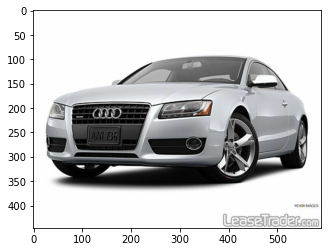

In [148]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

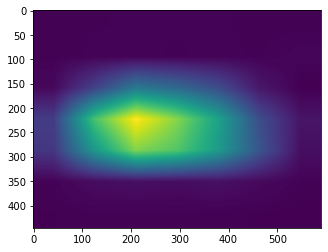

In [149]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [150]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

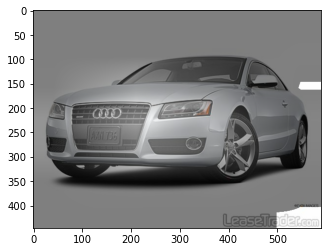

In [151]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

      이제 GRAD CAM을 확인해 봅니다. 
      
      grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 cam_image를 얻게 됩니다.

    위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

    아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.
    
    conv5_block3_out, conv4_block3_out, conv3_block3_out를 적용하여 각각 확인해봅니다.

In [152]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

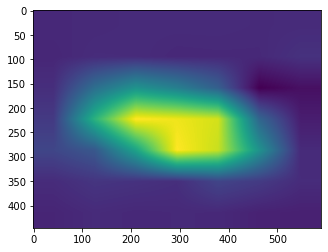

In [153]:
cam_model = tf.keras.models.load_model(cam_model_path)

grad_cam_image_1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_1)

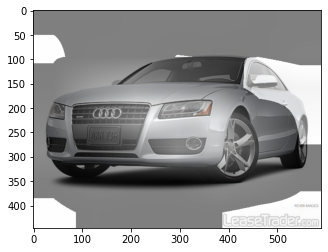

In [154]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_1_3channel = np.stack([grad_cam_image_1*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_1_3channel, origin_image)
plt.imshow(blended_image)

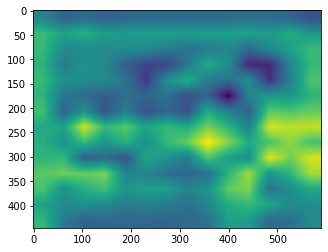

In [155]:
cam_model = tf.keras.models.load_model(cam_model_path)

grad_cam_image_2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_2)


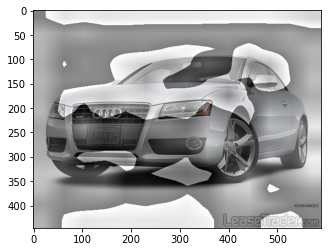

In [156]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_2_3channel = np.stack([grad_cam_image_2*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_2_3channel, origin_image)
plt.imshow(blended_image)

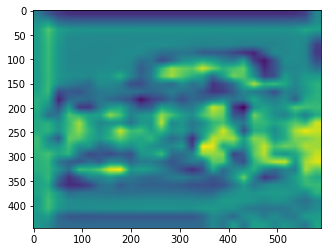

In [157]:
cam_model = tf.keras.models.load_model(cam_model_path)

grad_cam_image_3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image_3)

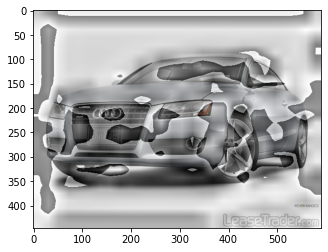

In [158]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3_3channel = np.stack([grad_cam_image_3*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3_3channel, origin_image)
plt.imshow(blended_image)

      콘볼루션 블럭의 차원이 높아질 수록 영역이 깔끔해지는것을 확인할 수 있었습니다.

## 4. CAM & GRAD-CAM 결과 비교하기

      이제 위에서 사용한 CAM과 3종의 GRAD CAM을 IoU를 이용하여 비교해봅니다.

In [159]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [160]:
image_original = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[  0, 103],
       [546, 103],
       [546, 348],
       [  0, 348]])

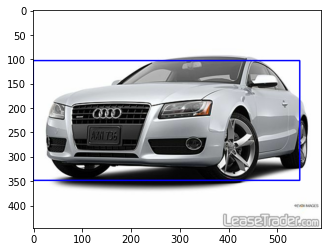

In [161]:
image = cv2.drawContours(image_original,[rect],0,(0,0,255),2)
plt.imshow(image)

In [162]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [163]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.23094170403587444, 0.0, 0.7802690582959642, 0.9254237288135593]

In [164]:
item['bbox']

array([0.20403588, 0.04576271, 0.7847534 , 0.9542373 ], dtype=float32)

In [165]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [166]:
get_iou(pred_bbox, item['bbox'])

0.8742840448599516

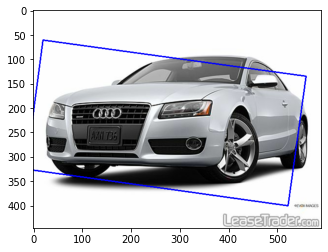

In [167]:
image_original = copy.deepcopy(item['image'])

rect_grad_1 = get_bbox(grad_cam_image_1)
rect_grad_1

image = cv2.drawContours(image_original,[rect_grad_1],0,(0,0,255),2)
plt.imshow(image)

In [168]:
pred_bbox_grad_1 = rect_to_minmax(rect_grad_1, item['image'])
pred_bbox_grad_1

[0.1367713004484305,
 -0.025423728813559324,
 0.8968609865470852,
 0.9474576271186441]

In [169]:
get_iou(pred_bbox_grad_1, item['bbox'])

0.704358425804413

0.5542141886846857

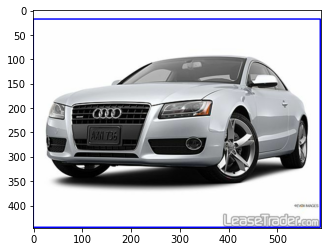

In [170]:
image_original = copy.deepcopy(item['image'])

rect_grad_2 = get_bbox(grad_cam_image_2)

image = cv2.drawContours(image_original,[rect_grad_2],0,(0,0,255),2)
plt.imshow(image)

pred_bbox_grad_2 = rect_to_minmax(rect_grad_2, item['image'])
get_iou(pred_bbox_grad_2, item['bbox'])

0.0

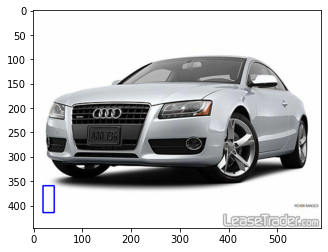

In [171]:
image_original = copy.deepcopy(item['image'])

rect_grad_3 = get_bbox(grad_cam_image_3)

image = cv2.drawContours(image_original,[rect_grad_3],0,(0,0,255),2)
plt.imshow(image)

pred_bbox_grad_3 = rect_to_minmax(rect_grad_3, item['image'])
get_iou(pred_bbox_grad_3, item['bbox'])

      확인결과, CAM과 conv5_block3_out을 이용한 GRAD CAM이 성능이 비슷하게 나왔고 conv4_block3_out과 conv3_block3_out를 사용한 GRAD CAM은 conv4_block3_out가 좀 더 인식이 잘 진행되었으나 다른 이미지에서는 둘 다 종종 인식에 실패하는 모습을 보여주었다.
     

***
# 총평 및 결론

      CAM과 conv5_block3_out GRAD CAM이 비슷한 성능을 보였고 다른 활성화 층을 가진 GRAD CAM은 오히려 성능이 떨어지거나 아예 인식에 실패하는 모습을 볼 수 있었다.